

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook accompanies our preprint: "*A deterministic, age-stratified, extended SEIRD model for assessing the effect of non-pharmaceutical interventions on SARS-CoV-2 spread in Belgium*"(https://doi.org/10.1101/2020.07.17.20156034)

# Load required packages

In [6]:
import random
import os
import numpy as np
import json
import corner
import random

import pandas as pd
import datetime
import scipy
import matplotlib.dates as mdates
import matplotlib
import math
import xarray as xr
import emcee
import matplotlib.pyplot as plt
import datetime

from covid19model.optimization import objective_fcns,pso
from covid19model.models import models
from covid19model.models.utils import draw_sample_COVID19_SEIRD_google
from covid19model.models.time_dependant_parameter_fncs import google_lockdown, ramp_fun, contact_matrix
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import model_parameters
from covid19model.visualization.output import population_status, infected, _apply_tick_locator 
from covid19model.visualization.optimization import plot_fit, traceplot


# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [7]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012')
levels = initN.size
Nc_all = {'total': Nc_total, 'home':Nc_home, 'work': Nc_work, 'schools': Nc_schools, 'transport': Nc_transport, 'leisure': Nc_leisure, 'others': Nc_others}


In [8]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano.tail(2)

,H_tot,ICU_tot,H_in,H_out,H_tot_cumsum,D_tot,D_25_44,D_45_64,D_65_74,D_75_84,D_85+
DATE,,,,,,,,,,,
2020-12-07,3276,723,144,65,3539,73,1.0,8.0,12,17,35
2020-12-08,3143,676,207,320,3426,10,0.0,0.0,2,4,4


In [9]:
df_google = google.get_google_mobility_data(update=False, plot=False)

# Contact matrix function

In [5]:
from functools import lru_cache

In [6]:
def make_contact_matrix_function(df_google, Nc_all):
    """
    Nc_all : dictionnary
            contact matrices for home, schools, work, transport, leisure and others
    df_google : dataframe
            google mobility data
    """

    
    df_google_array = df_google.values
    df_google_start = df_google.index[0]
    df_google_end = df_google.index[-1]

    @lru_cache() # once the function is run for a set of parameters, it doesn't need to compile again
    def contact_matrix(t, prev_home=1, prev_schools=1, prev_work=1, prev_transport=1, 
                       prev_leisure=1, prev_others=1,
                       school=None, work=None, transport=None, leisure=None, others=None):
        """
        t : timestamp
            current date
        prev_... : float [0,1]
            prevention parameter to estimate
        school, work, transport, leisure, others : float [0,1]
            level of opening of these sectors
            if None, it is calculated from google mobility data
            only school cannot be None!
        """

        if t < pd.Timestamp('2020-03-15'):
            CM = Nc_all['total']
        else:

            if school is None:
                raise ValueError(
                "Please indicate to which extend schools are open")

            if pd.Timestamp('2020-03-15') <= t <= df_google_end:
                #take t.date() because t can be more than a date! (e.g. when tau_days is added)
                idx = int((t - df_google_start) / pd.Timedelta("1 day")) 
                row = -df_google_array[idx]/100
            else:
                row = -df_google_array[-1]/100

            # columns: retail_recreation grocery parks transport work residential
            if work is None:
                work= 1-row[4]
            if transport is None:
                transport=1-row[3]
            if leisure is None:
                leisure=1-row[0]
            if others is None:
                others=1-row[1]

            CM = (prev_home*(1/2.3)*Nc_all['home'] + 
                  prev_schools*school*Nc_all['schools'] + 
                  prev_work*work*Nc_all['work'] + 
                  prev_transport*transport*Nc_all['transport'] + 
                  prev_leisure*leisure*Nc_all['leisure'] + 
                  prev_others*others*Nc_all['others']) 


        return CM

    
    @lru_cache() # once the function is run for a set of parameters, it doesn't need to compile again
    def contact_matrix_4prev(t, prev_home=1, prev_schools=1, prev_work=1, prev_rest = 1,
                       school=None, work=None, transport=None, leisure=None, others=None):
        """
        t : timestamp
            current date
        prev_... : float [0,1]
            prevention parameter to estimate
        school, work, transport, leisure, others : float [0,1]
            level of opening of these sectors
            if None, it is calculated from google mobility data
            only school cannot be None!
        """

        if t < pd.Timestamp('2020-03-15'):
            CM = Nc_all['total']
        else:

            if school is None:
                raise ValueError(
                "Please indicate to which extend schools are open")

            if pd.Timestamp('2020-03-15') <= t <= df_google_end:
                #take t.date() because t can be more than a date! (e.g. when tau_days is added)
                idx = int((t - df_google_start) / pd.Timedelta("1 day")) 
                row = -df_google_array[idx]/100
            else:
                row = -df_google_array[-1]/100

            # columns: retail_recreation grocery parks transport work residential
            if work is None:
                work= 1-row[4]
            if transport is None:
                transport=1-row[3]
            if leisure is None:
                leisure=1-row[0]
            if others is None:
                others=1-row[1]

            CM = (prev_home*(1/2.3)*Nc_all['home'] + 
                  prev_schools*school*Nc_all['schools'] + 
                  prev_work*work*Nc_all['work'] + 
                  prev_rest*transport*Nc_all['transport'] + 
                  prev_rest*leisure*Nc_all['leisure'] + 
                  prev_rest*others*Nc_all['others']) 


        return CM

    return contact_matrix, contact_matrix_4prev


In [10]:
from covid19model.models.time_dependant_parameter_fncs import make_contact_matrix_function
contact_matrix_6prev, contact_matrix_4prev = make_contact_matrix_function(df_google, Nc_all)

# Wave 2: September 2020 - present

In [11]:
with open('../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/google/initial_states_2020-09-01.json', 'r') as fp:
    initial_states = json.load(fp)    

In [12]:
# Start of data collection
start_data = '2020-09-01'
# Start data of recalibration ramp
start_calibration = '2020-09-01'
# Last datapoint used to recalibrate the ramp
end_calibration = '2020-12-08'
# Path where figures should be stored
fig_path = '../../results/calibrations/COVID19_SEIRD/national/'
# Path where MCMC samples should be saved
samples_path = '../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/'

## 6 prevention parameters

In [10]:
# Spatial unit: Belgium
spatial_unit = 'BE_6_prev_faster'

In [11]:
def wave2_policies(t, states, param, l , tau, 
                   prev_schools, prev_work, prev_transport, prev_leisure, prev_others, prev_home):
    
    # Convert tau and l to dates
    tau_days = pd.Timedelta(tau, unit='D')
    l_days = pd.Timedelta(l, unit='D')

    # Define additional dates where intensity or school policy changes
    t1 = pd.Timestamp('2020-03-15') # start of lockdown
    t2 = pd.Timestamp('2020-05-15') # gradual re-opening of schools (assume 50% of nominal scenario)
    t3 = pd.Timestamp('2020-07-01') # start of summer: COVID-urgency very low
    t4 = pd.Timestamp('2020-08-01')
    t5 = pd.Timestamp('2020-09-01') # september: lockdown relaxation narrative in newspapers reduces sense of urgency
    t6 = pd.Timestamp('2020-10-19') # lockdown
    t7 = pd.Timestamp('2020-11-16') # schools re-open
    t8 = pd.Timestamp('2020-12-18') # schools close
    t9 = pd.Timestamp('2021-01-04') # schools re-open

    if t5 < t <= t6 + tau_days:
        t = pd.Timestamp(t.date())
        return contact_matrix(t, school=1)
    elif t6 + tau_days < t <= t6 + tau_days + l_days:
        t = pd.Timestamp(t.date())
        policy_old = contact_matrix(t, school=1)
        policy_new = contact_matrix(t, prev_home, prev_schools, prev_work, prev_transport, 
                                    prev_leisure, prev_others, school=0)
        return ramp_fun(policy_old, policy_new, t, tau_days, l, t6)
    elif t6 + tau_days + l_days < t <= t7:
        t = pd.Timestamp(t.date())
        return contact_matrix(t, prev_home, prev_schools, prev_work, prev_transport, 
                              prev_leisure, prev_others, school=0)
    elif t7 < t <= t8:
        t = pd.Timestamp(t.date())
        return contact_matrix(t, prev_home, prev_schools, prev_work, prev_transport, 
                              prev_leisure, prev_others, school=1)
    elif t8 < t <= t9:
        t = pd.Timestamp(t.date())
        return contact_matrix(t, prev_home, prev_schools, prev_work, prev_transport, 
                              prev_leisure, prev_others, school=0)
    else:
        t = pd.Timestamp(t.date())
        return contact_matrix(t, prev_home, prev_schools, prev_work, prev_transport, 
                              prev_leisure, prev_others, school=1)



In [12]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

params.update({
               'l' : 5,
               'tau' : 5,
               'prev_schools': 0.5,
               'prev_work': 0.5,
               'prev_transport': 0.5,
               'prev_leisure': 0.5,
               'prev_others': 0.5,
               'prev_home' : 0.5
              })

# Initialize the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': wave2_policies})

In [13]:
# Set up the backend
results_folder = "../../results/calibrations/COVID19_SEIRD/national/backends/"
filename = spatial_unit+'_'+str(datetime.date.today())
backend = emcee.backends.HDFBackend(results_folder+filename)

# backend = emcee.backends.HDFBackend(filename) kan twee dingen doen:
# a) als filename al bestaat: leest die de sampler in filename in
# b) als filename nog niet bestaat: maakt die een file aan
## => geeft ws probleem als datetime verschillend is... dus dat uit filename laten?
## => wordt backend continu aangevuld tijdens runnen van emcee? => checken!

In [14]:
warmup=0
maxiter = 100
popsize = 100
processes = 6 # voor eraser!!
steps_mcmc = 30000#3000
discard = 1000

# define dataset
data=[df_sciensano['H_in'][start_calibration:end_calibration]]
states = [["H_in"]]

####################################################
####### CALIBRATING BETA AND COMPLIANCE RAMP #######
####################################################

print('------------------------------------')
print('CALIBRATING BETA AND COMPLIANCE RAMP')
print('------------------------------------\n')
print('Using data from '+start_calibration+' until '+end_calibration+'\n')
print('1) Particle swarm optimization\n')

# set PSO optimisation settings
parNames = ['sigma_data','beta','l','tau',
            'prev_schools', 'prev_work', 'prev_transport', 'prev_leisure', 'prev_others', 'prev_home']
bounds=((1,2000),(0.010,0.060),(0.1,20),(0.1,20),
        (0,1),(0,1),(0,1),(0,1),(0,1),(0,1))

# run PSO optimisation
theta = pso.fit_pso(model,data,parNames,states,bounds,maxiter=maxiter,popsize=popsize,
                    start_date=start_calibration,warmup=warmup, processes=processes) ## PROCESSES=1 to debug!


------------------------------------
CALIBRATING BETA AND COMPLIANCE RAMP
------------------------------------

Using data from 2020-09-01 until 2020-12-08

1) Particle swarm optimization

No constraints given.
Best after iteration 1: [2.31134166e+02 2.55863054e-02 1.70084592e+01 9.85902511e+00
 2.35703296e-01 8.98555151e-01 8.18758337e-01 6.35420081e-02
 1.19868015e-01 7.93379150e-01] 557.9979795808258
Best after iteration 2: [2.31134166e+02 2.55863054e-02 1.70084592e+01 9.85902511e+00
 2.35703296e-01 8.98555151e-01 8.18758337e-01 6.35420081e-02
 1.19868015e-01 7.93379150e-01] 557.9979795808258
Best after iteration 3: [2.31134166e+02 2.55863054e-02 1.70084592e+01 9.85902511e+00
 2.35703296e-01 8.98555151e-01 8.18758337e-01 6.35420081e-02
 1.19868015e-01 7.93379150e-01] 557.9979795808258
Best after iteration 4: [2.31134166e+02 2.55863054e-02 1.70084592e+01 9.85902511e+00
 2.35703296e-01 8.98555151e-01 8.18758337e-01 6.35420081e-02
 1.19868015e-01 7.93379150e-01] 557.9979795808258


Process ForkPoolWorker-3:
Process ForkPoolWorker-6:
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Process ForkPoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/ho

  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 252, in __call__
    return self._call_impl(t)
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/scipy/integrate/_ivp/rk.py", line 144, in _step_impl
    y_new, f_new = rk_step(self.fun, t, y, self.f, h, self.A,
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 20, in fun_wrapped
    return np.asarray(fun(t, y), dtype=dtype)
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/scipy/integrate/_ivp/rk.py", line 544, in _call_impl
    y += self.y_old[:, None]
  File "/home/twallema/Documents/PhD/Corona/Python/git/COVID19-Model/src/covid19model/optimization/pso.py", line 7, in _obj_wrapper
    return func(x, *args, **kwargs)
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/scipy/integrate/_ivp/rk.py", line 64, in rk_step
    K[s] = f

KeyboardInterrupt: 

In [ ]:

# run MCMC sampler
print('\n2) Markov-Chain Monte-Carlo sampling\n')
parNames_mcmc = parNames
bounds_mcmc=((1,2000),(0.020,0.060),(0.001,20),(0.001,20),
             (0,1),(0,1),(0,1),(0,1),(0,1),(0,1))

ndim = len(theta)
nwalkers = ndim*2
perturbations = ([1]+(ndim-1)*[1e-3]) * np.random.randn(nwalkers, ndim)
pos = theta + perturbations

sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability, backend=backend,
                    args=(model, bounds_mcmc, data, states, parNames_mcmc, None, start_calibration, warmup))
sampler.run_mcmc(pos, steps_mcmc, progress=True)

thin = 0
try:
    autocorr = sampler.get_autocorr_time()
    thin = int(0.5 * np.min(autocorr))
except:
    print('Warning: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s).\nUse this estimate with caution and run a longer chain!')
    sampler.run_mcmc(initial_state=None, nsteps=steps_mcmc, progress=True)
from covid19model.optimization.run_optimization import checkplots
checkplots(sampler, discard, thin, fig_path, spatial_unit, figname='BETA_RAMP_GOOGLE_WAVE2', 
           labels=['$\sigma_{data}$','$\\beta$','l','$\\tau$',
                   'prev_schools', 'prev_work', 'prev_transport', 'prev_leisure', 'prev_others', 'prev_home'])

#############################################
####### Output to dictionary ################
#############################################

flat_samples = sampler.get_chain(discard=discard,thin=thin,flat=True)

samples_dict_wave2 = {}
for count,name in enumerate(parNames_mcmc):
    samples_dict_wave2[name] = flat_samples[:,count].tolist()

samples_dict_wave2.update({
    'theta_pso' : list(theta_pso),
    'warmup' : warmup,
    'calibration_data' : states[0][0],
    'start_date' : start_calibration,
    'end_date' : end_calibration,
    'maxiter' : maxiter,
    'popsize': popsize,
    'steps_mcmc': steps_mcmc,
    'discard' : discard,
})

with open(samples_path+str(spatial_unit)+'_'+str(datetime.date.today())+'_WAVE2_GOOGLE.json', 'w') as fp:
    json.dump(samples_dict_wave2, fp)


2) Markov-Chain Monte-Carlo sampling



  0%|          | 0/30000 [00:00<?, ?it/s]/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 11%|█         | 3207/30000 [2:33:46<22:24:26,  3.01s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 28%|██▊       | 8485/30000 [6:35:54<14:43:44,  2.46s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (se

In [ ]:
# Checken waar stopcriterium zit
chains = sampler.get_chain()
step_autocorr = 100
tau_vect = np.empty((len(chains)//step_autocorr-1,ndim))
index = 0
for i in range(step_autocorr, len(chains), step_autocorr):
    tau_vect[index] = emcee.autocorr.integrated_time(chains[:i], tol = 0)
    index += 1
n = step_autocorr * np.arange(1, index + 1)
plt.plot(n, n / step_autocorr, "--k")
plt.plot(n, tau_vect)
plt.xlim(0, n.max())
plt.xlabel("number of steps")
plt.ylabel(r"$\hat{\tau}$");

In [ ]:
fig,ax = plt.subplots()
plt.hist(samples_dict_wave2['prev_schools'])

In [ ]:
end_sim = '2021-01-01'

fig,ax=plt.subplots(figsize=(10,4))
for i in range(100):
    # Sampling
    idx, model.parameters['beta'] = random.choice(list(enumerate(samples_dict_wave2['beta'])))
    model.parameters['l'] = samples_dict_wave2['l'][idx] 
    model.parameters['tau'] = samples_dict_wave2['tau'][idx]    
    model.parameters['prev_schools'] = samples_dict_wave2['prev_schools'][idx]    
    model.parameters['prev_work'] = samples_dict_wave2['prev_work'][idx]     
    model.parameters['prev_transport'] = samples_dict_wave2['prev_transport'][idx]    
    model.parameters['prev_leisure'] = samples_dict_wave2['prev_leisure'][idx]     
    model.parameters['prev_others'] = samples_dict_wave2['prev_others'][idx]      

    # Simulate
    y_model = model.sim(end_sim,start_date=start_calibration,warmup=0)
    # Plot
    ax.plot(y_model['time'],y_model["H_in"].sum(dim="Nc"),color='blue',alpha=0.05)

ax.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_in'][start_calibration:end_calibration],color='black',alpha=0.6,linestyle='None',facecolors='none')
ax = _apply_tick_locator(ax)
ax.set_xlim('2020-09-01',end_sim)
fig.savefig(fig_path+'others/FIT_WAVE2_GOOGLE_'+spatial_unit+'_'+str(datetime.date.today())+'.pdf', dpi=400, bbox_inches='tight')

## 4 prevention parameters

In [7]:
from covid19model.models.time_dependant_parameter_fncs import wave2_policies_4prev, make_contact_matrix_function
contact_matrix_6prev, contact_matrix_4prev = make_contact_matrix_function(df_google, Nc_all)

In [15]:
def wave2_policies_4prev(t, states, param, l , tau, 
                   prev_schools, prev_work, prev_rest, prev_home):
    
    # Convert tau and l to dates
    tau_days = pd.Timedelta(tau, unit='D')
    l_days = pd.Timedelta(l, unit='D')

    # Define additional dates where intensity or school policy changes
    t1 = pd.Timestamp('2020-03-15') # start of lockdown
    t2 = pd.Timestamp('2020-05-15') # gradual re-opening of schools (assume 50% of nominal scenario)
    t3 = pd.Timestamp('2020-07-01') # start of summer: COVID-urgency very low
    t4 = pd.Timestamp('2020-08-01')
    t5 = pd.Timestamp('2020-09-01') # september: lockdown relaxation narrative in newspapers reduces sense of urgency
    t6 = pd.Timestamp('2020-10-19') # lockdown
    t7 = pd.Timestamp('2020-11-16') # schools re-open
    t8 = pd.Timestamp('2020-12-18') # schools close
    t9 = pd.Timestamp('2021-01-04') # schools re-open

    if t5 < t <= t6 + tau_days:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, school=1)
    elif t6 + tau_days < t <= t6 + tau_days + l_days:
        t = pd.Timestamp(t.date())
        policy_old = contact_matrix_4prev(t, school=1)
        policy_new = contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                    school=0)
        return ramp_fun(policy_old, policy_new, t, tau_days, l, t6)
    elif t6 + tau_days + l_days < t <= t7:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
    elif t7 < t <= t8:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=1)
    elif t8 < t <= t9:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
    else:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=1)



In [16]:
# Spatial unit: Belgium
spatial_unit = 'BE_4_prev_full'

In [17]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

params.update({'l' : 5,
               'tau' : 5,
               'prev_schools': 0.5,
               'prev_work': 0.5,
               'prev_rest': 0.5,
               'prev_home' : 0.5,
              })

# Initialize the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': wave2_policies_4prev})

In [10]:
warmup=0
maxiter = 100
popsize = 100
processes = 6 # voor eraser!!
steps_mcmc = 3000#3000
discard = 1000#1000

# define dataset
data=[df_sciensano['H_in'][start_calibration:end_calibration]]
states = [["H_in"]]

In [11]:
####################################################
####### CALIBRATING BETA AND COMPLIANCE RAMP #######
####################################################

print('------------------------------------')
print('CALIBRATING BETA AND COMPLIANCE RAMP')
print('------------------------------------\n')
print('Using data from '+start_calibration+' until '+end_calibration+'\n')
print('1) Particle swarm optimization\n')

# set PSO optimisation settings
parNames = ['sigma_data','beta','l','tau',
            'prev_schools', 'prev_work', 'prev_rest', 'prev_home']
bounds=((1,2000),(0.010,0.060),(0.1,20),(0.1,20),
        (0,1),(0,1),(0,1),(0,1))

# run PSO optimisation
theta = pso.fit_pso(model,data,parNames,states,bounds,maxiter=maxiter,popsize=popsize,
                    start_date=start_calibration,warmup=warmup, processes=processes) ## PROCESSES=1 to debug!



------------------------------------
CALIBRATING BETA AND COMPLIANCE RAMP
------------------------------------

Using data from 2020-09-01 until 2020-12-08

1) Particle swarm optimization

No constraints given.


NameError: name 'contact_matrix_4prev' is not defined

In [ ]:
# run MCMC sampler
print('\n2) Markov-Chain Monte-Carlo sampling\n')
parNames_mcmc = parNames
bounds_mcmc=((1,2000),(0.020,0.060),(0.001,20),(0.001,20),
             (0,1),(0,1),(0,1),(0,1))

ndim = len(theta)
nwalkers = ndim*2
perturbations = ([1]+(ndim-1)*[1e-3]) * np.random.randn(nwalkers, ndim)
pos = theta + perturbations

sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                    args=(model, bounds_mcmc, data, states, parNames_mcmc, None, start_calibration, warmup))
sampler.run_mcmc(pos, steps_mcmc, progress=True)

thin = 0
try:
    autocorr = sampler.get_autocorr_time()
    thin = int(0.5 * np.min(autocorr))
except:
    print('Warning: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s).\nUse this estimate with caution and run a longer chain!')
from covid19model.optimization.run_optimization import checkplots
checkplots(sampler, discard, thin, fig_path, spatial_unit, figname='BETA_RAMP_GOOGLE_WAVE2', 
           labels=['$\sigma_{data}$','$\\beta$','l','$\\tau$',
                   'prev_schools', 'prev_work', 'prev_rest', 'prev_home'])

#############################################
####### Output to dictionary ################
#############################################

flat_samples = sampler.get_chain(discard=discard,thin=thin,flat=True)

samples_dict_wave2 = {}
for count,name in enumerate(parNames_mcmc):
    samples_dict_wave2[name] = flat_samples[:,count].tolist()

samples_dict_wave2.update({
    'theta_pso' : list(theta_pso),
    'warmup' : warmup,
    'calibration_data' : states[0][0],
    'start_date' : start_calibration,
    'end_date' : end_calibration,
    'maxiter' : maxiter,
    'popsize': popsize,
    'steps_mcmc': steps_mcmc,
    'discard' : discard,
})

with open(samples_path+str(spatial_unit)+'_'+str(datetime.date.today())+'_WAVE2_GOOGLE.json', 'w') as fp:
    json.dump(samples_dict_wave2, fp)

In [ ]:
fig,ax = plt.subplots()
plt.hist(samples_dict_wave2['prev_rest'])

In [18]:
with open('../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/BE_4_prev_full_2020-12-10_WAVE2_GOOGLE.json', 'r') as fp:
    samples_dict_wave2 = json.load(fp)    

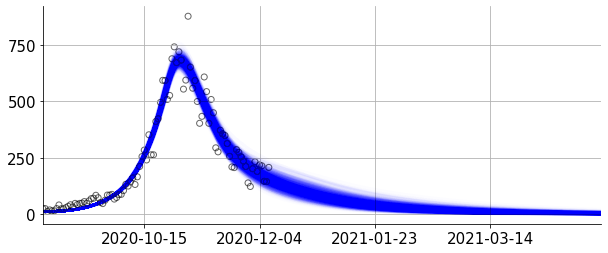

In [21]:
end_sim = '2021-05-01'

fig,ax=plt.subplots(figsize=(10,4))
for i in range(2000):
    # Sampling
    idx, model.parameters['beta'] = random.choice(list(enumerate(samples_dict_wave2['beta'])))
    model.parameters['l'] = samples_dict_wave2['l'][idx] 
    model.parameters['tau'] = samples_dict_wave2['tau'][idx]    
    model.parameters['prev_schools'] = samples_dict_wave2['prev_schools'][idx]    
    model.parameters['prev_work'] = samples_dict_wave2['prev_work'][idx]       
    model.parameters['prev_rest'] = samples_dict_wave2['prev_rest'][idx]      

    # Simulate
    y_model = model.sim(end_sim,start_date=start_calibration,warmup=0)
    # Plot
    ax.plot(y_model['time'],y_model["H_in"].sum(dim="Nc"),color='blue',alpha=0.002)

ax.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_in'][start_calibration:end_calibration],color='black',alpha=0.6,linestyle='None',facecolors='none')
ax = _apply_tick_locator(ax)
ax.set_xlim('2020-09-01',end_sim)
fig.savefig(fig_path+'others/FIT_WAVE2_GOOGLE_'+spatial_unit+'_'+str(datetime.date.today())+'.pdf', dpi=400, bbox_inches='tight')